## **Importing: Numpy, Pandas, Scikit-Learn, Seaborn, Matplotlib**

In [0]:
import math
import numpy as np 
import pandas as pd
import sklearn 
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
#mpl.rc('axes', labelsize=14)
#mpl.rc('xtick', labelsize=12)
#mpl.rc('ytick', labelsize=12)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Uploading and Accessing the New York City Airbnb data from 2019, https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data

In [0]:
#from google.colab import files
#uploaded = files.upload()
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## **Looking at the Big Picture**
Welcome to our NYC (Not **NY**iregyhaza **C**ity) AirBnB Price Prediction Modelling Group or as we like to call ourselves Goal Diggers (No, **NOT** Gold Diggers)  
The data includes *latitude and longitude of properties, room_type, price, min nights, # of reviews, reviwews/month, host listing and days availabe for booking*.  

Our target variable is the price. 

# **Framing the problem**
1.   Business Objective: Prediction of any NYC Airbnb property price/night
2.   The Frame:

  *   A supervised learning task (as each instance comes with a price)
  *   A regression (specifically multiple and univariate regression) task as having many attributes for making prediction and only trying to predict a single value, respectively 
  *   Offline learning task aka once the system is trained, it is put into use w/o learning it anymore 

3. Performance Measure (Cost Function for Regression): 


*   **RMSE (Root Mean Square Error)** is typical for regression tasks. The underlying idea behind is how much the system typically makes in its predictions, w/ a heigher weight for large errors:
> $ RMSE(\textbf{X}, f)= \sqrt{\dfrac{1}{n} \sum_{i=1}^{n} \, (f( \textbf{x}_{i}) - y_{i})^2}$ 

  where n: # of instances in the data set; $\textbf{x}_i$ is a vector of containing all the attributes excl. the dependent variables (ala price) of the $i^{th}$ instance; $y_{i}$ is the output for that instance;  $f$ is the prediction function $==>$ $\hat{y_{i}} = f(\textbf{x}_i)$
*   **MAE (Mean Absolute Error)**   is another possibility cost function for a regression task: 
> $ MAE(\textbf{X}, f)= \dfrac{1}{n} \sum_{i=1}^{n} \, |f( \textbf{x}_{i}) - y_{i}|$

* Both RMSE and MAE are norms ($L_2$ and $L_1 \, $ respectively}. 
Let's see which one is better for our purpose.   




















In [0]:
nycAB_orig = pd.read_csv('gdrive/My Drive/ELTE-GoalDiggers_DAMN/NYC_AB_2019.csv')

In [0]:
priceSeries_orig = nycAB_orig['price']
plt.figure(figsize=(10,7))
priceSeries_orig.plot.density()

In [0]:
nycAB_orig.info()

In [0]:
nycAB_orig.describe()

In [0]:
nycAB_orig['neighbourhood_group'].value_counts()

In [0]:
nycAB_orig["room_type"].value_counts()

# **Framing the problem** (cont.)
*   The plot shows tail-heaviness at the right end, that is, in our context, there are very few outliers $==>$ **RMSE** is the preferred choice for a cost function/performance measurement tool  

# **A sneak peak into the data structure**
*   head() and info() method (see above): 
  *   Each row depicts a property with a unique id 
  *   16 features, 48895 instances
  *   6 attributes are text, all other are numerical
  *   In the info() method, it can be clearly seen that *last_review* and *reviews_per_month* have more than 10.052 missing entries => should treat this later on. 

*   describe() method (see above): 
  *   Some descriptive statisitics could be read for each numerical feature 







In [0]:
nycAB_orig.hist(bins=30, figsize=(30,22))

In [0]:
logPrice = np.log(nycAB_orig["price"])
plt.figure(figsize=(10,7))
sns.set(style="whitegrid")
ax = sns.boxplot(x=logPrice)

In [0]:
sns.set(style="whitegrid")
sns.distplot(nycAB_orig["price"], bins = 30)

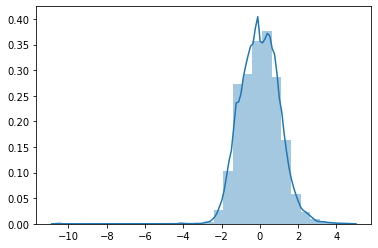

In [0]:
from sklearn import preprocessing
from sklearn.preprocessing import PowerTransformer
trialdf = pd.DataFrame(nycAB_orig, columns= ["price"])
pt = preprocessing.PowerTransformer(method='yeo-johnson')
modified_price = pt.fit_transform(trialdf)
sns.distplot(modified_price, bins = 30)  #With Yeo-Johnson transformation our price variable now looks more like a Gaussaian distro

In [0]:
nycAB_orig.isnull().sum()

# **A sneak peak into the data structure** (cont.)
*   Histogram (what can be noticed): 
  *   Most histograms tends to skewed to the left, aka tail-heavy at the right end $-->$ Try to transform them to have more bell-shaped-like distro.
  *   Features gave wide range of scales. Feature scaling is needed before feeding into the system. 
  *   latitude and longitude histograms' resemble a normal-like distribution $-->$ Properties concentrate on more of a central location of NYC (like Manhattan, Brooklyn) - it will be seen through data visulaization, too.    





# **Creating a Train, Validation, Test Set**
*   Train/Test = 80/20
*   Train ---> TrainReduced/Valid = 80/20
*   Want to make sure our test set is representative of the universe so a good idea to implement **stratified sampling**. In other words, the data points are allocated to their respective homogenous subgroups called strata, and the appropirate # of data entries are sampled from each stratum. This way, representativeness can be ensured.
*   Doing Stratified sampling according to *neighboorhood_group* or *room_type*
*   Creating strata based on a better representative feature 






In [0]:
nycAB_orig['neighbourhood_group'].hist()
nycAB_orig["neighbourhood_group"].value_counts() / len(nycAB_orig)

In [0]:
nycAB_orig['room_type'].hist()
nycAB_orig["room_type"].value_counts() / len(nycAB_orig)

### Creating Train and Test Set 

In [0]:
from sklearn.model_selection import StratifiedShuffleSplit

randState = 69  ## initialize random state for replicability 
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state= randState)

#for train_index, test_index in split.split(nycAB_orig, nycAB_orig["neighbourhood_group"]):
for train_index, test_index in split.split(nycAB_orig, nycAB_orig["room_type"]):
  stratified_train_set_trial = nycAB_orig.loc[train_index]
  stratified_test_set_trial = nycAB_orig.loc[test_index]

#stratified_test_set_trial["neighbourhood_group"].value_counts() / len(stratified_test_set_trial)  #Checking the distro of test set 
stratified_test_set_trial["room_type"].value_counts() / len(stratified_test_set_trial)  #Checking the distro of test set 

Entire home/apt    0.519685
Private room       0.456591
Shared room        0.023724
Name: room_type, dtype: float64

In [0]:
stratified_test_set_trial["neighbourhood_group"].value_counts() / len(stratified_test_set_trial)  #Checking the distro of test set 

In [0]:
from sklearn.model_selection import StratifiedShuffleSplit

randState = 69  ## initialize random state for replicability 
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state= randState)

for train_index, test_index in split.split(nycAB_orig, nycAB_orig["neighbourhood_group"]):
#for train_index, test_index in split.split(nycAB_orig, nycAB_orig["room_type"]):
  stratified_train_set = nycAB_orig.loc[train_index]
  stratified_test_set = nycAB_orig.loc[test_index]

stratified_test_set["neighbourhood_group"].value_counts() / len(stratified_test_set)  #Checking the distro of test set 
#stratified_test_set["room_type"].value_counts() / len(stratified_test_set)  #Checking the distro of test set 

Manhattan        0.442990
Brooklyn         0.411187
Queens           0.115861
Bronx            0.022293
Staten Island    0.007669
Name: neighbourhood_group, dtype: float64

In [0]:
stratified_test_set["room_type"].value_counts() / len(stratified_test_set)

In [0]:
(stratified_test_set_trial["neighbourhood_group"].value_counts() / len(stratified_test_set_trial)) / (stratified_test_set["neighbourhood_group"].value_counts() / len(stratified_test_set)) - 1

In [0]:
(stratified_test_set_trial["room_type"].value_counts() / len(stratified_test_set_trial)) / (stratified_test_set["room_type"].value_counts() / len(stratified_test_set)) -1

Should base our stratified sampling on *neighbourhood_group*, the differences are more distributed among the categories within neighboor_hood_group than in the case of *room_type*

In [0]:
len(stratified_train_set)

39116

In [0]:
dummyIndex = pd.Index(np.arange(len(stratified_train_set)))
dummyStrat_trainSet = stratified_train_set.set_index(dummyIndex)   #Creating a DummyTrainSet by setting a new index that is in-order, important when it comes to do stratified 

### Creating Reduced Train and Validation Set 

In [0]:
for trainRed_index, valid_index in split.split(dummyStrat_trainSet, dummyStrat_trainSet["neighbourhood_group"]):
#for trainRed_index, valid_index in split.split(dummyStrat_trainSet, dummyStrat_trainSet["room_type"]):
  stratified_trainRed_set = dummyStrat_trainSet.loc[trainRed_index]
  stratified_valid_set = dummyStrat_trainSet.loc[valid_index]

stratified_valid_set["neighbourhood_group"].value_counts() / len(stratified_valid_set)  #Checking the distro of test set
#stratified_valid_set["room_type"].value_counts() / len(stratified_valid_set)  #Checking the distro of test set  

Manhattan        0.442996
Brooklyn         0.411171
Queens           0.115925
Bronx            0.022367
Staten Island    0.007541
Name: neighbourhood_group, dtype: float64

# **Creating a Test Set** (cont.)
*   3 strata --- Entire home/apt, Private room , Shared room
*   Comparing the test set with the universe, it could be seen we achived our goals of having very similar location distribution in the test set compared to the original data set $==>$ representiveness is ensured. 
*   After creating test set, we put it on hold until doing fine-tuning on training set
*   From now on, we are gonna exploring training set, but before that the training set needs to be copied 



In [0]:
nycAB = stratified_train_set.copy()  #Creating a copy of the training set and gonna tinker the copied version 

# **Looking at the Data Structure Again and Now Tinkering it** 
1.   Visualizations
2.   Sepaerating the predictors and the target variable as we would not want to apply the same transformations to the predictors and target values
3.   Now we are allowed to make modifications/transformations/adjustments on the (copied) training set 
4.  Data Cleaning and Imputatuion 
5.   Feature Engineering (Feature Selection, Feature Extraction) 
6.   Transoformation Scaling 





In [0]:
nycAB.info()

In [0]:
nycAB.describe()

In [0]:
print(f"Average of price per night : ${nycAB.price.mean():.2f}")
print(f"Maximum price per night : ${nycAB.price.max()}")
print(f"Minimum price per night : ${nycAB.price.min()}") #There are some free houses 

Average of price per night : $152.30
Maximum price per night : $10000
Minimum price per night : $0


# Visualizing the data 
*   Try to visualize train set properties on a scatter plot based on their longitude and latitude data for discovering high-density areas and how prices vary in those areas 



In [0]:
nycAB.hist(bins=30, figsize=(30,22))

Latitude and Longitude follows a kinda normal distributions $==>$ properties concantrated around on those areas mostly (Manhattan and Brooklyn as we would see later on)

In [0]:
sns.countplot(nycAB['neighbourhood_group'], palette="bright")
fig = plt.gcf()
fig.set_size_inches(7,7)
plt.title('Neighbourhood Group')

In [0]:
plt.figure(figsize=(10,10))
sns.boxplot(x='neighbourhood_group',y='availability_365',palette='bright', data=nycAB)
plt.title('Neighbourhood Group and Availability')

In [0]:
top5Neighbourhood = nycAB.neighbourhood.value_counts().head(5)
sns.barplot(x = top5Neighbourhood.index, y = top5Neighbourhood.values, palette = 'bright')
fig = plt.gcf()
fig.set_size_inches(10,7)
plt.title('TOP5 Neighbourhood')

In [0]:
sns.countplot(nycAB['room_type'], palette="bright")
fig = plt.gcf()
fig.set_size_inches(7,7)
plt.title('Room Type')

In [0]:
sns.countplot(nycAB['room_type'], hue=nycAB['neighbourhood_group'], palette="bright")
fig = plt.gcf()
fig.set_size_inches(15,8)
plt.title('Room Type Based on Neighboorhood Group')

In [0]:
plt.figure(figsize=(10,10))
sns.scatterplot(x = nycAB['longitude'], y= nycAB['latitude'], hue=nycAB['neighbourhood_group'], palette='bright')
plt.show()

In [0]:
plt.figure(figsize=(10,10))
sns.scatterplot(x = nycAB['longitude'], y= nycAB['latitude'], hue=nycAB['room_type'], palette='colorblind')
plt.show()

In [0]:
nycAB.plot(kind="scatter", x="longitude", y="latitude", alpha=0.3, figsize=(20,14), title = "Log price distribution over NYC AirBnb",
    c=np.log(nycAB['price']), cmap=plt.get_cmap("jet"),  colorbar=True, sharex=False)

# **Discover Correlations**
*   Our interest is how price correlates w/ other features 
*   Even though it's important to measure correlation, it may miss capturing non-linear realtionships between attributes 






In [0]:
corrMtx = nycAB.corr()
corrMtx["price"].sort_values(ascending=False)

In [0]:
plt.figure(figsize=(15,8))
sns.heatmap(corrMtx, annot=True, linewidths=0.1, cmap='Reds')
plt.title('Correlation Matrix Heatmap')

# **Experimanting with attributes**

In [0]:
nycAB['month'] = nycAB['number_of_reviews']/nycAB['reviews_per_month']

In [0]:
corrMtx = nycAB.corr()
corrMtx["price"].sort_values(ascending=False)

In [0]:
nycAB.drop(['month'], axis=1, inplace=True) #length of month when reviewd took place is irrelevant so drop it 

In [0]:
from pandas.plotting import scatter_matrix 
features = ["host_id" ,"availability_365", "minimum_nights", "reviews_per_month", "price"]
scatter_matrix(nycAB[features], figsize=(15,15))

Availability_365 - most hosts are not available, price - most host has a price under 1000

# Seperating predictors from target variable

In [0]:
nycAB = stratified_train_set.copy()
nycAB_tRed_set = stratified_trainRed_set.copy()
nycAB_valid_set = stratified_valid_set.copy()

nycAB = stratified_train_set.drop('price', axis=1)
nycAB_tRed_set = stratified_trainRed_set.drop('price', axis=1)
nycAB_valid_set = stratified_valid_set.drop('price', axis=1)

#nycAB_target = stratified_train_set['price'].copy()
#nycAB_tRed_target = stratified_trainRed_set['price'].copy()
#nycAB_valid_target = stratified_valid_set['price'].copy()

nycAB_target = pd.DataFrame(stratified_train_set, columns= ["price"])
nycAB_tRed_target = pd.DataFrame(stratified_trainRed_set, columns= ["price"])
nycAB_valid_target = pd.DataFrame(stratified_valid_set, columns= ["price"])

# **Data Cleaning, Imputing and Feature Selection**

In [0]:
#nycAB.info()

# "*It is not from the benevolence of the butcher, the brewer, or the baker that we expect our dinner, but from their regard to their own interest.*" 
---
Adam Smith


# **Handling Categorical Features and Feature Scaling**  
*   Two categorical attributes: neighbourhood_group and room_type
*   For having better performance, we may need to use standardization as feature scaling. It subtracts the mean so the standardized values have a zero mean then it divides by the Standard Deviation $==>$ The resulting distro has **unit variance** 
*  (Min-Max scaling is also a solution but it bounds a value to specific range, usually 0-1 by subtracting the min then divede it by max-min)

In [0]:

#list0Price = nycAB[nycAB.price == 0].index #list of free goodies 
#list0Price #there are 6 of it 

def dropUnnecessary(df, df_target, dropList, boolVar = True):  
  temp_df = df.assign(price = df_target)
  list0Price_index = temp_df[temp_df.price == 0].index
  df_new = df.drop_duplicates() #If duplicates exist, drop them
  df_new.drop(dropList, axis=1, inplace=True)  #dropping features in the "dropList" list 
  #df_new['reviews_per_month'].fillna(value='median', inplace=True)
  df_new.drop(['reviews_per_month'], axis=1, inplace=True)
  df_new.dropna(how='all') #drop an instance if all are NA's
  if boolVar:
    df_target_new = df_target.drop(list0Price_index) #Assumption: See the quotes above  ==> Dropping entries where price = 0
    df_new.drop(list0Price_index, inplace=True) #Dropping the corresponding rows
  else:
    df_target_new = df_target.copy()
  return df_new, df_target_new

#dropList = ['name','host_name','last_review','host_id', 'neighbourhood', 'id']

#nycAB_imputed, nycAB_imputed_target = dropUnnecessary(nycAB, nycAB_target, dropList)

def dropCategorical(df):
  dropList1 = df.select_dtypes(include=['object']).columns
  df_num = df.drop(dropList1, axis=1)
  return df_num 

#nycAB_imputed_num = dropCategorical(nycAB_imputed)

#nycAB_num = nycAB.drop(['neighbourhood_group', 'room_type'], axis=1) #dropping categorical variables, only numerical features remain

def puredVersion(df, df_target, dropList, boolVar = True):
  imputed, imputed_target = dropUnnecessary(df, df_target, dropList, boolVar)
  imputed_num = dropCategorical(imputed)

  return imputed, imputed_num, imputed_target

#dropList = ['name','host_name','last_review','host_id', 'neighbourhood', 'id']
#nycAB_imputed, nycAB_imputed_num, nycAB_imputed_target = puredVersion(nycAB, nycAB_target, dropList)

# **Transformation Pipelines**

In [0]:
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer

def df_proccessed(df, df_target, dropList, desired_cat_attr, boolVar = True, full_pipeline = None, pT = None):
  imputed, imputed_num, imputed_target = puredVersion(df, df_target, dropList, boolVar)

  #num_pipeline = Pipeline([('std_scaler', StandardScaler())])    
  num_pipeline = Pipeline([('yeo-john', PowerTransformer(method='yeo-johnson'))]) #optional parameter of Powertransformer is standardize which is by default is standardize = True

  if pT is None: 
    pT = preprocessing.PowerTransformer(method='yeo-johnson') #transforming the target variable
    targetTransform = pT.fit(imputed_target)
    imputed_target_ready = targetTransform.transform(imputed_target)
  else:
    targetTransform = pT
    imputed_target_ready = targetTransform.transform(imputed_target)

  num_attr = list(imputed_num)

  if full_pipeline is None: 
    full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attr),
        ("cat", OneHotEncoder(), desired_cat_attr)])
    
    fittedColumnTransform = full_pipeline.fit(imputed)
    df_ready = fittedColumnTransform.transform(imputed)
  else:
    fittedColumnTransform = full_pipeline
    df_ready = fittedColumnTransform.transform(imputed)

  return df_ready, imputed_target_ready, fittedColumnTransform, targetTransform

# **Selecting and Trainaing Models** on Reduced Training Set and Evaluating on the Validation Set

## **Linear Regression** --- Plain Vanila

### Transformation of the data on the REDUCED Training Set

### PCA (some experiment)

In [0]:
corrMtx = nycAB_orig.corr()
corrMtx["price"].sort_values(ascending=False)

In [0]:
from sklearn.decomposition import PCA

#dropList_original = ['name','host_name','last_review','neighbourhood', 'host_id', 'id']  # It turned out that "latitude can be eliminated from features with which the explained variance will not be dropped under 0.95"
dropList = ['name','host_name','last_review','neighbourhood', 'host_id', 'id', 'latitude']
desired_cat_attr = ['room_type','neighbourhood_group']
boolVar = True
nycAB_ready, nycAB_imputed_target = df_proccessed(nycAB, nycAB_target, dropList, desired_cat_attr, boolVar)

pca = PCA(n_components = 0.95)
trial_nycAB_ready = pca.fit_transform(nycAB_ready)
(pca.n_components_, np.sum(pca.explained_variance_ratio_)) #It turns out that latitude is the one is not needed
#pca.components_

----------------------------

In [0]:
#dropList = ['name','host_name','last_review','neighbourhood','host_id', 'id']
dropList = ['name','host_name','last_review','neighbourhood','host_id', 'id', 'latitude']
desired_cat_attr = ['room_type','neighbourhood_group']
boolVar = True

In [0]:
nycAB_tRed_set['neighbourhood'].value_counts()   #why neighbourhood can't be categorized into desired_cat_attr -> there will be instances in the validation set where there wouldn't be cases from the neighbourhood appered in the reduced training set

In [0]:
nycAB_ready, nycAB_imputed_target, fittedColumnTransform, targetTransform = df_proccessed(nycAB, nycAB_target, dropList, desired_cat_attr, boolVar)   #Full training set imputation and transformation
X_trRed, Y_trRed, fittedColumnTransform, targetTransform = df_proccessed(nycAB_tRed_set, nycAB_tRed_target, dropList, desired_cat_attr, boolVar)      #Reduced training set imputation and transformation 
X_valid, Y_valid, _, _ = df_proccessed(nycAB_valid_set, nycAB_valid_target, dropList, desired_cat_attr, boolVar, full_pipeline=fittedColumnTransform, pT=targetTransform)    #Validation Set imputation and transformation 

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2951: RuntimeWarning: overflow encountered in power
  out[~pos] = -(np.power(-x[~pos] + 1, 2 - lmbda) - 1) / (2 - lmbda)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:199: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2951: RuntimeWarning: overflow encountered in power
  out[~pos] = -(np.power(-x[~pos] + 1, 2 - lmbda) - 1) / (2 - lmbda)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:199: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


### Training of the REDUCED Training Set  


In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lin1_reg = LinearRegression()
lin1_reg.fit(X_trRed, Y_trRed)
Y_trPred_lin1 = lin1_reg.predict(X_trRed)
lin1_trPred_mse = mean_squared_error(Y_trRed, Y_trPred_lin1)
lin1_trPred_rmse = np.sqrt(lin1_trPred_mse)

print("LinReg Train RMSE:", lin1_trPred_rmse)

LinReg Train RMSE: 0.6770193694707001


### Evaluation on the Validation Set



In [0]:
Y_validPred_lin1 = lin1_reg.predict(X_valid)

lin1_validPred_mse = mean_squared_error(Y_valid, Y_validPred_lin1)
lin1_validPred_rmse = np.sqrt(lin1_validPred_mse)

print("LinReg Validation RMSE:", lin1_validPred_rmse)

LinReg Validation RMSE: 0.6965595664918152


## **Linear Regression** --- Plain Vanila but w/ a K-fold Cross-Validation Spice (Using entire full Training Set) 
*   The reason why we do not need validation set is defined in the definition of K-fold Cross-Validation (let's say K=10, so the training set will be randomly split into 10 folds (aka subsets), and the chosen model (now Lin Reg) will be trained and evaluated 10 times, **choosing a different fold every time** as a validation set and training on the other 9 folds.
In this way, we could also get a glimpse of whether the training set is overfitted or not. 

*   By default Sklearn's CV expects a utility function instead of cost function used by Regression models' as performance measurement. So the scoring function used by Sklearn's CV has to be a negated MSE, that's why in the code you see $\text{-lin_score}$



In [0]:
from sklearn.model_selection import cross_val_score

def display_scores(scores):
  print("Scores:", scores)
  print("Mean:", scores.mean())
  print("Standard deviation:", scores.std())

lin1_scores = cross_val_score(lin1_reg, nycAB_ready, nycAB_imputed_target, scoring="neg_mean_squared_error", cv=6)
lin1_rmse_scores = np.sqrt(-lin1_scores)
 
display_scores(lin1_rmse_scores)

Scores: [0.67304163 0.67829413 0.69321752 0.6892309  0.65613561 0.67924484]
Mean: 0.6781941041835943
Standard deviation: 0.011984385682370549


## **Linear Regression w/ Stochastic Gradient Descent** 

### Training of the REDUCED Training Set  

In [0]:
from sklearn.linear_model import SGDRegressor

sgd1_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty="l2", eta0=0.1, random_state = randState)
sgd1_reg.fit(X_trRed, Y_trRed)
Y_trPred_sgd1 = sgd1_reg.predict(X_trRed)
sgd1_trPred_mse = mean_squared_error(Y_trRed, Y_trPred_sgd1)
sgd1_trPred_rmse = np.sqrt(sgd1_trPred_mse)

sgd1_trPred_rmse

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6841943750286406

### Evaluation on the Validation Set


In [0]:
Y_validPred_sgd1 = sgd1_reg.predict(X_valid)

sgd1_validPred_mse = mean_squared_error(Y_valid, Y_validPred_sgd1)
sgd1_validPred_rmse = np.sqrt(sgd1_validPred_mse)

print("SGD Validation RMSE:", sgd1_validPred_rmse)

SGD Validation RMSE: 0.7021693327067585


In [0]:
sgd1_scores = cross_val_score(sgd1_reg, nycAB_ready, nycAB_imputed_target, scoring="neg_mean_squared_error", cv=6) #Cross-validation
sgd1_rmse_scores = np.sqrt(-sgd1_scores)
 
display_scores(sgd1_rmse_scores)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

Scores: [0.67741988 0.68909422 0.70842648 0.70692585 0.65766735 0.68406838]
Mean: 0.6872670252989609
Standard deviation: 0.017420625523434027


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## **K-nearest Neighbour** 

In [0]:
from sklearn.neighbors import KNeighborsRegressor
kNN1_reg = KNeighborsRegressor(n_neighbors = 5)
kNN1_reg.fit(X_trRed, Y_trRed)

Y_trPred_kNN1 = kNN1_reg.predict(X_trRed)
kNN1_mse = mean_squared_error(Y_trRed, Y_trPred_kNN1)
kNN1_rmse = np.sqrt(kNN1_mse)

kNN1_rmse

0.5515750403299964

In [0]:
Y_validPred_kNN1 = kNN1_reg.predict(X_valid)

kNN1_validPred_mse = mean_squared_error(Y_valid, Y_validPred_kNN1)
kNN1_validPred_rmse = np.sqrt(kNN1_validPred_mse)

print("kNN Validation RMSE:", kNN1_validPred_rmse)

kNN Validation RMSE: 0.7001383146532633


In [0]:
kNN1_scores = cross_val_score(kNN1_reg, nycAB_ready, nycAB_imputed_target, scoring="neg_mean_squared_error", cv=6)
kNN1_rmse_scores = np.sqrt(-kNN1_scores)
 
display_scores(kNN1_rmse_scores)

Scores: [0.67048095 0.67800489 0.69153497 0.68799269 0.65542435 0.67963811]
Mean: 0.6771793256928373
Standard deviation: 0.011887580752855318


## **SVM w/ Linear Kernel** 

```
# This is formatted as code
```



### Training of the REDUCED Training Set  

In [0]:
from sklearn.svm import SVR
svmLin1_reg = SVR(kernel="linear", epsilon=1.5, C=1)
svmLin1_reg.fit(X_trRed, Y_trRed)

Y_trPred_svmLin1 = svmLin1_reg.predict(X_trRed)
svmLin1_trPred_mse = mean_squared_error(Y_trRed, Y_trPred_svmLin1)
svmLin1_trPred_rmse = np.sqrt(svmLin1_trPred_mse)

svmLin1_trPred_rmse 

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.694403453376022

### Evaluation on the Validation Set


In [0]:
Y_validPred_svmLin1 = svmLin1_reg.predict(X_valid)

svmLin1_validPred_mse = mean_squared_error(Y_valid, Y_validPred_svmLin1)
svmLin1_validPred_rmse = np.sqrt(svmLin1_validPred_mse)

print("SVM Lin Validation RMSE:", svmLin1_validPred_rmse)

SVM Lin Validation RMSE: 0.7145975811681351


## **SVM w/ Linear Kernel** --- w/ Cross-Validation 

In [0]:
from sklearn.model_selection import cross_val_score

svmLin1_scores = cross_val_score(svmLin1_reg, nycAB_ready, nycAB_imputed_target, scoring="neg_mean_squared_error", cv=6)
svmLin1_rmse_scores = np.sqrt(-svmLin1_scores)
 
display_scores(svmLin1_rmse_scores)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

Scores: [0.68706439 0.69772816 0.71343889 0.70534433 0.67279616 0.7023015 ]
Mean: 0.6964455698041149
Standard deviation: 0.013236306712198633


## **SVM w/ Polynomial Kernel** 

### Training of the REDUCED Training Set  

In [0]:
svmPoly1_reg = SVR(kernel="poly", degree = 3, C=0.5, epsilon = 0.1)
svmPoly1_reg.fit(X_trRed, Y_trRed)

Y_trPred_svmPoly1 = svmPoly1_reg.predict(X_trRed)
svmPoly1_trPred_mse = mean_squared_error(Y_trRed, Y_trPred_svmPoly1)
svmPoly1_trPred_rmse = np.sqrt(svmPoly1_trPred_mse)

svmPoly1_trPred_rmse 

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6400747655202298

### Evaluation on the Validation Set


In [0]:
Y_validPred_svmPoly1 = svmPoly1_reg.predict(X_valid)

svmPoly1_validPred_mse = mean_squared_error(Y_valid, Y_validPred_svmPoly1)
svmPoly1_validPred_rmse = np.sqrt(svmPoly1_validPred_mse)

print("SVM Poly=3 Validation RMSE:", svmPoly1_validPred_rmse)

SVM Poly=3 Validation RMSE: 0.6674254285744798


## **Decision Tree** --- Plain Vanila

In [0]:
from sklearn.tree import DecisionTreeRegressor

tree1_reg = DecisionTreeRegressor(random_state = randState)
tree1_reg.fit(X_trRed, Y_trRed)

Y_trPred_tree1 = tree1_reg.predict(X_trRed)
tree1_trPred_mse = mean_squared_error(Y_trRed, Y_trPred_tree1)
tree1_trPred_rmse = np.sqrt(tree1_trPred_mse)

tree1_trPred_rmse

0.03131662931292293

#### Decision Tree seems an awesome method, but the problem is that it overfits badly to the training model so it will give us awful result on unseen data points as the Cross-Validation is gonna show us.

Now let's look at it using Cross-Validation (also using the full training set)

In [0]:
from sklearn.model_selection import cross_val_score

tree1_scores = cross_val_score(tree1_reg, nycAB_ready, nycAB_imputed_target, scoring="neg_mean_squared_error", cv=6)
tree1_rmse_scores = np.sqrt(-tree1_scores)
 
display_scores(tree1_rmse_scores)

Scores: [0.87787965 0.89216259 0.89809072 0.89449501 0.87461973 0.89352271]
Mean: 0.8884617360784345
Standard deviation: 0.008869509390698298


## **Decision Tree** w/ max depth = 5

In [0]:
tree2_reg = DecisionTreeRegressor(max_depth = 5, random_state = randState)
tree2_reg.fit(X_trRed, Y_trRed)

Y_trPred_tree2 = tree2_reg.predict(X_trRed)
tree2_trPred_mse = mean_squared_error(Y_trRed, Y_trPred_tree2)
tree2_trPred_rmse = np.sqrt(tree2_trPred_mse)

tree2_trPred_rmse

0.6632261068779348

In [0]:
Y_validPred_tree2 = tree2_reg.predict(X_valid)

tree2_validPred_mse = mean_squared_error(Y_valid, Y_validPred_tree2)
tree2_validPred_rmse = np.sqrt(tree2_validPred_mse)

print("Decision Tree w/ max depth = 5 Validation RMSE:", tree2_validPred_rmse)

Decision Tree w/ max depth = 5 Validation RMSE: 0.6885434720031092


In [0]:
tree2_scores = cross_val_score(tree2_reg, nycAB_ready, nycAB_imputed_target, scoring="neg_mean_squared_error", cv=6)
tree2_rmse_scores = np.sqrt(-tree2_scores)
 
display_scores(tree2_rmse_scores)

Scores: [0.66554071 0.66730154 0.68666371 0.68015732 0.64892283 0.67328592]
Mean: 0.6703120038528776
Standard deviation: 0.011989424333457904


## **RandomForest** --- Plain Vanila

### Training of the REDUCED Training Set  

In [0]:
from sklearn.ensemble import RandomForestRegressor

RF1_reg = RandomForestRegressor(n_estimators=100, random_state= randState)
RF1_reg.fit(X_trRed, Y_trRed)

Y_trPred_RF1 = RF1_reg.predict(X_trRed)
RF1_trPred_mse = mean_squared_error(Y_trRed, Y_trPred_RF1)
RF1_trPred_rmse = np.sqrt(RF1_trPred_mse)

print("RF Train RMSE:", RF1_trPred_rmse)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RF Train RMSE: 0.2431135766732536


### Evaluation on the Validation Set


In [0]:
Y_validPred_RF1 = RF1_reg.predict(X_valid)

RF1_validPred_mse = mean_squared_error(Y_valid, Y_validPred_RF1)
RF1_validPred_rmse = np.sqrt(RF1_validPred_mse)

print("RF Validation RMSE:", RF1_validPred_rmse)

RF Validation RMSE: 0.672242347333742


#### The Plain RandomForest seems to overfit badly, that is, it performs much worse on the validation set. 

Now let's look at it using Cross-Validation (also using the full training set)

In [0]:
from sklearn.model_selection import cross_val_score

RF1_scores = cross_val_score(RF1_reg, nycAB_ready, nycAB_imputed_target, scoring="neg_mean_squared_error", cv=6)
RF1_rmse_scores = np.sqrt(-RF1_scores)
 
display_scores(RF1_rmse_scores)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 

Scores: [0.64170246 0.65003458 0.66284811 0.6588487  0.62750402 0.65429809]
Mean: 0.649205992634028
Standard deviation: 0.011782641966441196


## **RandomForest** --- with parameters 

In [0]:
RF2_reg = RandomForestRegressor(n_estimators=100, max_depth=4, max_leaf_nodes = 10 , n_jobs = -1, random_state = randState, bootstrap = True)
RF2_reg.fit(X_trRed, Y_trRed)

Y_trPred_RF2 = RF2_reg.predict(X_trRed)
RF2_trPred_mse = mean_squared_error(Y_trRed, Y_trPred_RF2)
RF2_trPred_rmse = np.sqrt(RF2_trPred_mse)

print("RF Train RMSE:", RF2_trPred_rmse)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RF Train RMSE: 0.6825570799904598


In [0]:
Y_validPred_RF2 = RF2_reg.predict(X_valid)

RF2_validPred_mse = mean_squared_error(Y_valid, Y_validPred_RF2)
RF2_validPred_rmse = np.sqrt(RF2_validPred_mse)

print("RF Validation RMSE:", RF2_validPred_rmse)

RF Validation RMSE: 0.7073539647191357


In [0]:
RF2_scores = cross_val_score(RF2_reg, nycAB_ready, nycAB_imputed_target, scoring="neg_mean_squared_error", cv=6)
RF2_rmse_scores = np.sqrt(-RF2_scores)
 
display_scores(RF2_rmse_scores)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 

Scores: [0.68091343 0.68317891 0.70198945 0.69707887 0.66678066 0.6840463 ]
Mean: 0.6856646034113484
Standard deviation: 0.011436496171292011


## **Voting Regressor**
The following regressions will be used in Voting Regressions 

*   Linear Regression (lin1_reg)
*   kNN (kNN1_reg)
*   SVM w/ polynomial kernel (svmPoly1_reg)
*   Random Forest (RF2_reg)


In [0]:
from sklearn.ensemble import VotingRegressor
voting1_reg = VotingRegressor(
    estimators = [('lr', lin1_reg), ('kNN', kNN1_reg), ('svmPoly', svmPoly1_reg), ('RF', RF2_reg)])

voting1_reg.fit(X_trRed, Y_trRed)

Y_trPred_voting1 = voting1_reg.predict(X_trRed)
voting1_trPred_mse = mean_squared_error(Y_trRed, Y_trPred_voting1)
voting1_trPred_rmse = np.sqrt(voting1_trPred_mse)

print("Voting Regression Train RMSE:", voting1_trPred_rmse)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_voting.py:406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Voting Regression Train RMSE: 0.6104252386890783


In [0]:
Y_validPred_voting1 = voting1_reg.predict(X_valid)

voting1_validPred_mse = mean_squared_error(Y_valid, Y_validPred_voting1)
voting1_validPred_rmse = np.sqrt(voting1_validPred_mse)

print("voting1 Validation RMSE:", voting1_validPred_rmse)

voting1 Validation RMSE: 0.665955584955596


In [0]:
voting1_scores = cross_val_score(voting1_reg, nycAB_ready, nycAB_imputed_target, scoring="neg_mean_squared_error", cv=6)
voting1_rmse_scores = np.sqrt(-voting1_scores)
 
display_scores(voting1_rmse_scores)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_voting.py:406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_voting.py:406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_voting.py:406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_voting.py:406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

Scores: [0.6386587  0.644272   0.65993866 0.65582505 0.62208668 0.64456403]
Mean: 0.6442241874093592
Standard deviation: 0.012265712881171323


## **Bagging and Pasting**



In [0]:
from sklearn.ensemble import BaggingRegressor
bagging1_reg = BaggingRegressor(
    DecisionTreeRegressor(), n_estimators = 100, max_samples = 100, bootstrap = True, n_jobs = - 1
)

bagging1_reg.fit(X_trRed, Y_trRed)

Y_trPred_bagging1 = bagging1_reg.predict(X_trRed)
bagging1_trPred_mse = mean_squared_error(Y_trRed, Y_trPred_bagging1)
bagging1_trPred_rmse = np.sqrt(bagging1_trPred_mse)

print("Bagging Regression Train RMSE:", bagging1_trPred_rmse)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_bagging.py:399: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


Bagging Regression Train RMSE: 0.6708369352569942


In [0]:
Y_validPred_bagging1 = bagging1_reg.predict(X_valid)

bagging1_validPred_mse = mean_squared_error(Y_valid, Y_validPred_bagging1)
bagging1_validPred_rmse = np.sqrt(bagging1_validPred_mse)

print("Bagging Validation RMSE:", bagging1_validPred_rmse)

Bagging Validation RMSE: 0.7000352346110781


In [0]:
bagging1_scores = cross_val_score(bagging1_reg, nycAB_ready, nycAB_imputed_target, scoring="neg_mean_squared_error", cv=6)
bagging1_rmse_scores = np.sqrt(-bagging1_scores)
 
display_scores(bagging1_rmse_scores)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_bagging.py:399: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_bagging.py:399: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_bagging.py:399: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_bagging.py:399: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

Scores: [0.66485569 0.67099331 0.68612644 0.68388092 0.6453357  0.67441233]
Mean: 0.6709340669044966
Standard deviation: 0.013557004019087238


## **Gradient Boosting - XGBoost** --- Vanila

In [0]:
import xgboost as xgb

xgb1_reg = xgb.XGBRegressor()
xgb1_reg.fit(X_trRed, Y_trRed)

Y_trPred_xgb1 = xgb1_reg.predict(X_trRed)
xgb1_trPred_mse = mean_squared_error(Y_trRed, Y_trPred_xgb1)
xgb1_trPred_rmse = np.sqrt(xgb1_trPred_mse)

print("XGB Vanila Regression Train RMSE:", xgb1_trPred_rmse)

[19:06:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB Vanila Regression Train RMSE: 0.6289953500708941


In [0]:
Y_validPred_xgb1 = xgb1_reg.predict(X_valid)

xgb1_validPred_mse = mean_squared_error(Y_valid, Y_validPred_xgb1)
xgb1_validPred_rmse = np.sqrt(xgb1_validPred_mse)

print("XGB Vanila Validation RMSE:", xgb1_validPred_rmse)

XGB Vanila Validation RMSE: 0.6557793381635324


In [0]:
xgb1_scores = cross_val_score(xgb1_reg, nycAB_ready, nycAB_imputed_target, scoring="neg_mean_squared_error", cv=6)
xgb1_rmse_scores = np.sqrt(-xgb1_scores)
 
display_scores(xgb1_rmse_scores)

[19:06:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:06:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:06:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:06:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:06:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:06:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Scores: [0.6326556  0.63662044 0.65267554 0.64854479 0.61228828 0.63776281]
Mean: 0.6367579111855933
Standard deviation: 0.012967406030822448


## **Gradient Boosting - XGBoost** --- with Parameters

In [0]:
xgb2_reg = xgb.XGBRegressor(max_depth=4, learning_rate = 0.1, n_estimators=200, booster = 'gbtree')
xgb2_reg.fit(X_trRed, Y_trRed)

Y_trPred_xgb2 = xgb2_reg.predict(X_trRed)
xgb2_trPred_mse = mean_squared_error(Y_trRed, Y_trPred_xgb2)
xgb2_trPred_rmse = np.sqrt(xgb2_trPred_mse)

print("XGB2 Regression Train RMSE:", xgb2_trPred_rmse)

[19:06:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB2 Regression Train RMSE: 0.605860401908973


In [0]:
Y_validPred_xgb2 = xgb2_reg.predict(X_valid)

xgb2_validPred_mse = mean_squared_error(Y_valid, Y_validPred_xgb2)
xgb2_validPred_rmse = np.sqrt(xgb2_validPred_mse)

print("XGB2 Validation RMSE:", xgb2_validPred_rmse)

XGB2 Validation RMSE: 0.6461874451978745


In [0]:
xgb2_scores = cross_val_score(xgb2_reg, nycAB_ready, nycAB_imputed_target, scoring="neg_mean_squared_error", cv=6)
xgb2_rmse_scores = np.sqrt(-xgb2_scores)
 
display_scores(xgb2_rmse_scores)

[19:06:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:06:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:06:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:07:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:07:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:07:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Scores: [0.62262961 0.62962516 0.64479525 0.64077438 0.60583447 0.63087602]
Mean: 0.6290891494587402
Standard deviation: 0.012709658347000469


## **Stacking** --- with Parameters --- "Unfinished"

In [0]:
from sklearn.ensemble import StackingRegressor

In [0]:
from sklearn.ensemble import StackingRegressor
stack1_reg = StackingRegressor(
    estimators = [('lr', lin1_reg), ('kNN', kNN1_reg), ('svmPoly', svmPoly1_reg), ('XGB2', xgb2_reg)], cv = 6)

stack1_reg.fit(nycAB_ready, nycAB_imputed_target)



# **Choosing 4-6 Promising Models and Fine-tune those models with the help of GridSearchCV**

In [0]:
from sklearn.model_selection import GridSearchCV

## **RandomForest**

In [0]:
param_grid_RF3 = [
    {'n_estimators': [10, 50], 'max_depth' : [3,6], 'min_samples_split' : [2,4], 'max_features' : [3,6]},
    {'bootstrap': [False], 'n_estimators': [10, 50], 'max_depth' : [3,6], 'min_samples_split' : [2,4], 'max_features' : [3,6]},
]

RF3_reg = RandomForestRegressor()

grid_search_RF3 = GridSearchCV(RF3_reg, param_grid_RF3, cv=6, scoring='neg_mean_squared_error', return_train_score=True)

grid_search_RF3.fit(nycAB_ready, nycAB_imputed_target)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 

GridSearchCV(cv=6, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, rand...
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=None,
  

In [0]:
print(grid_search_RF3.best_params_)
print(grid_search_RF3.best_estimator_)

{'max_depth': 6, 'max_features': 6, 'min_samples_split': 2, 'n_estimators': 50}
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=6, max_features=6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)


In [0]:
cvRes_RF3 = grid_search_RF3.cv_results_
for mean_score, params in zip(cvRes_RF3["mean_test_score"], cvRes_RF3["params"]):
  if params == grid_search_RF3.best_params_:
    print(np.sqrt(-mean_score), params) #206.78076493823684

0.6539593263330141 {'max_depth': 6, 'max_features': 6, 'min_samples_split': 2, 'n_estimators': 50}


## **Regularized Linear Regression** w/ SGD 

In [0]:
param_grid_sgd2 = [
    {'loss' : ['squared_loss', 'huber', 'epsilon_insensitive'], 'penalty' : ['l2', 'l1', 'elasticnet'], 'alpha': [0.0001, 0.005, 0.1, 1],
     'epsilon' : [0.1, 0.01], 'random_state' : [randState], 'eta0' : [0.1, 0.01]},
]

sgd2_reg = SGDRegressor()
grid_search_sgd2 = GridSearchCV(sgd2_reg, param_grid_sgd2, cv=6, scoring='neg_mean_squared_error', return_train_score=True)
grid_search_sgd2.fit(nycAB_ready, nycAB_imputed_target)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

GridSearchCV(cv=6, error_score=nan,
             estimator=SGDRegressor(alpha=0.0001, average=False,
                                    early_stopping=False, epsilon=0.1,
                                    eta0=0.01, fit_intercept=True,
                                    l1_ratio=0.15, learning_rate='invscaling',
                                    loss='squared_loss', max_iter=1000,
                                    n_iter_no_change=5, penalty='l2',
                                    power_t=0.25, random_state=None,
                                    shuffle=True, tol=0.001,
                                    validation_fraction=0.1, verbose=0,
                                    warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': [0.0001, 0.005, 0.1, 1],
                          'epsilon': [0.1, 0.01], 'eta0': [0.1, 0.01],
                          'loss': ['squared_loss', 'huber',
                                   'epsilon_inse

In [0]:
print(grid_search_sgd2.best_params_)
print(grid_search_sgd2.best_estimator_)

{'alpha': 0.0001, 'epsilon': 0.1, 'eta0': 0.01, 'loss': 'squared_loss', 'penalty': 'l2', 'random_state': 69}
SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=69,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)


In [0]:
cvRes_sgd2 = grid_search_sgd2.cv_results_
for mean_score, params in zip(cvRes_sgd2["mean_test_score"], cvRes_sgd2["params"]):
  if params == grid_search_sgd2.best_params_:
    print(np.sqrt(-mean_score), params) #212.22885387569934 (Actually a slightly worse than the barely parametrized sgd1)

0.6801556394235344 {'alpha': 0.0001, 'epsilon': 0.1, 'eta0': 0.01, 'loss': 'squared_loss', 'penalty': 'l2', 'random_state': 69}


## **Bagging and Pasting** 


In [0]:
param_grid_bag2 = [
    {'base_estimator': [SVR(), DecisionTreeRegressor()], 'n_estimators': [10, 50, 100], 'max_features' : [2,6], 'max_samples' : [1,10,100], 'random_state' : [randState]},
    {'bootstrap': [False], 'base_estimator': [SVR(), DecisionTreeRegressor()], 'n_estimators': [10, 50, 100], 'max_features' : [2,6], 'max_samples' : [1,10,100], 'random_state' : [randState]},
] 

bag2_reg = BaggingRegressor()

grid_search_bag2 = GridSearchCV(bag2_reg, param_grid_bag2, cv=6, scoring='neg_mean_squared_error', return_train_score=True)

grid_search_bag2.fit(nycAB_ready, nycAB_imputed_target)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_bagging.py:399: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_bagging.py:399: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_bagging.py:399: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_bagging.py:399: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

GridSearchCV(cv=6, error_score=nan,
             estimator=BaggingRegressor(base_estimator=None, bootstrap=True,
                                        bootstrap_features=False,
                                        max_features=1.0, max_samples=1.0,
                                        n_estimators=10, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'base_estimator': [SVR(C=1.0, cache_size=200,
                                                 coef0=0.0, degree=3,
                                                 ep...
                                                                   min_impurity_split=None,
                                                                   min_samples_leaf=1,
                                                                   min_samples_split=2,
                      

In [0]:
print(grid_search_bag2.best_params_)
print(grid_search_bag2.best_estimator_)

{'base_estimator': DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best'), 'max_features': 6, 'max_samples': 100, 'n_estimators': 100, 'random_state': 69}
BaggingRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                      criterion='mse',
                                                      max_depth=None,
                                                      max_features=None,
                                                      max_leaf_nodes=None,
                                                      min_impurity_decrease=0.0,
                                                      min_im

In [0]:
cvRes_bag2 = grid_search_bag2.cv_results_
for mean_score, params in zip(cvRes_bag2["mean_test_score"], cvRes_bag2["params"]):
  if params == grid_search_bag2.best_params_:
    print(np.sqrt(-mean_score), params) #Worse than what we could ahived when we did it in bagging1

0.7072549143430154 {'base_estimator': DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best'), 'max_features': 6, 'max_samples': 100, 'n_estimators': 100, 'random_state': 69}


## **Gradient Boosting - XGBoost** --- with Parameters

In [0]:
param_grid_xgb3 = [
    {'booster': ['gbtree'], 'eta': [0.03, 0.3], 'max_depth' : [3,6], 'gamma' : [0,10,100], 'max_features' : [3,6], 'subsample': [0.6, 0.9]},
    #{'booster': ['gblinear'], 'updater': ['shotgun', 'coord_descent'], 'feature_selector' : ['cyclic', 'shuffle']},
    #{'booster': ['gblinear'],  'updater': ['shotgun', 'coord_descent'], 'feature_selector' : ['thrifty', 'greedy'], 'top_k' : [0, 2, 3]}
]

xgb3_reg = xgb.XGBRegressor()

grid_search_xgb3 = GridSearchCV(xgb3_reg, param_grid_xgb3, cv=6, scoring='neg_mean_squared_error', return_train_score=True)

grid_search_xgb3.fit(nycAB_ready, nycAB_imputed_target)

[19:21:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:22:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:22:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:22:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:22:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:22:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:22:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:22:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

GridSearchCV(cv=6, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid=[{'booster': ['gbtree'], 'eta': [0.03, 0.3],
                          'gamma': [0, 10, 100], 'max_depth': [

In [0]:
print(grid_search_xgb3.best_params_)
print(grid_search_xgb3.best_estimator_)

{'booster': 'gbtree', 'eta': 0.03, 'gamma': 0, 'max_depth': 6, 'max_features': 3, 'subsample': 0.9}
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.03, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=6, max_features=3, min_child_weight=1, missing=None,
             n_estimators=100, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.9, verbosity=1)


In [0]:
cvRes_xgb3 = grid_search_xgb3.cv_results_
for mean_score, params in zip(cvRes_xgb3["mean_test_score"], cvRes_xgb3["params"]):
  if params == grid_search_xgb3.best_params_:
    print(np.sqrt(-mean_score), params) #Worse than what we could ahived when we did it in bagging1

0.6249506128312856 {'booster': 'gbtree', 'eta': 0.03, 'gamma': 0, 'max_depth': 6, 'max_features': 3, 'subsample': 0.9}


The Winner is the XGBoost.

# **Last Steps** 

In [0]:
final_model = grid_search_xgb3.best_estimator_

## **Running the final, selected model on the Test Set**

In [0]:
X_test = stratified_test_set.copy()
X_test = stratified_test_set.drop('price', axis=1)
Y_test = pd.DataFrame(stratified_test_set, columns= ["price"])

dropList = ['name','host_name','last_review','host_id', 'neighbourhood', 'id']
desired_cat_attr = ['neighbourhood_group', 'room_type']
boolVar = True

x_test_ready, y_test_ready, _, _ = df_proccessed(X_test, Y_test, dropList, desired_cat_attr, boolVar, full_pipeline=fittedColumnTransform, pT=targetTransform)    #Test Set imputation and transformation 

/usr/local/lib/python3.6/dist-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


In [0]:
final_pred = final_model.predict(x_test_ready)

final_mse = mean_squared_error(y_test_ready, final_pred)
final_rmse = np.sqrt(final_mse)
print(final_rmse) #0.6438339121694955

0.6438339121694955
